In [1]:
from sage.schemes.elliptic_curves.all import *

In [2]:
R.<u,v,w,s,t> = QQ[]
S.<a,b> = QQ[]
hom_R_S = R.hom([0,0,0,a,b], S)

In [3]:
P = 10*u^3+v^3+3/10*w^3+v^2*w-w^2*v+u*v*w
Q = u^2*v+v^3+5*w^3 + v^2 * w-1/10*u*v*w

In [4]:
pol = Jacobian(s*P+t*Q,variables=[u,v,w]).j_invariant()

In [4]:
# Sage code: stereographic projection of divisor on P^1 to the unit sphere
# Paste into a Sage session (or SageCell). Requires matplotlib (shipped with Sage).
from sage.all import *
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D   # registers 3D projection

def stereographic_map(z):
    """
    Stereographically project complex number z (affine coordinate) to unit sphere (x,y,z3).
    North pole (0,0,1) corresponds to z = infinity.
    """
    x0 = float(z.real)
    y0 = float(z.imag)
    r2 = x0*x0 + y0*y0
    denom = 1.0 + r2
    x = 2.0 * x0 / denom
    y = 2.0 * y0 / denom
    z3 = (r2 - 1.0) / denom
    return (x, y, z3)

def plot_divisor_on_sphere_extra(f, tol=1e-8, sphere_res=60, figsize=(8,8), show_mult_labels=True,frame=False):
    """
    f : homogeneous polynomial in R.<s,t> (Sage polynomial)
    tol: tolerance for numeric clustering (used in fallback numeric rootfinding)
    """
    # basic checks
    R = f.parent()
    gens = R.gens()
    if len(gens) < 2:
        raise ValueError("Input polynomial must be in two variables s,t.")
    s, t = gens[0], gens[1]
    d = f.total_degree()
    if d <= 0:
        raise ValueError("Polynomial must have positive degree.")
    # collect homogeneous coefficients a_i for s^i t^(d-i)
    const_ring = R.base_ring()
    a = [ const_ring(f.coefficient(s**i * t**(d-i))) for i in range(d+1) ]  # a[0]..a[d]
    print(a)
    # build affine polynomial h(z) = f(z,1) = sum_{i=0..d} a_i z^i
    # Try exact root extraction first (works well for rational/coefficient polynomials)
    base = f.base_ring()
    z = polynomial_ring = PolynomialRing(base, 'z').gen()
    h = sum( a[i]*z**i for i in range(d+1) )
    finite_roots = []   # list of (complex_value, multiplicity)
    # Try exact roots if possible
    #try:
        # For polynomials over QQ (or number fields) .roots(multiplicities=True) typically returns algebraic roots
     #   exact = h.roots(multiplicities=True)
      #  if exact:
       #     for root, mult in exact:
                # convert algebraic root to complex approximation for plotting
                # root may be an algebraic number or a complex; use .n() to get numeric
        #        root_c = complex(root.n()) if hasattr(root, 'n') else complex(root)
         #       finite_roots.append((root_c, int(mult)))
    #except Exception:
     #   exact = []
    # If exact failed or returned no roots but degree>0, fallback to numeric using CC
    if not finite_roots:
        try:
            h_cc = h.change_ring(CC)
            # h_cc.roots() returns list of (root, multiplicity) in CC in recent Sage versions
            roots_cc = h_cc.roots(multiplicities=True)
            if roots_cc:
                for root, mult in roots_cc:
                    finite_roots.append((complex(root), int(mult)))
            else:
                # As another fallback use numpy.roots on coefficient list
                coeffs = [ complex(ai) for ai in a[::-1] ]  # numpy expects highest-first
                roots_np = np.roots(coeffs)
                # cluster nearby roots into multiplicities
                used = np.zeros(len(roots_np), dtype=bool)
                for i,r in enumerate(roots_np):
                    if used[i]:
                        continue
                    mult = 1
                    used[i] = True
                    for j in range(i+1, len(roots_np)):
                        if not used[j] and abs(roots_np[j]-r) < tol:
                            mult += 1
                            used[j] = True
                    finite_roots.append((complex(r), int(mult)))
        except Exception:
            # ultimate fallback: numpy.roots directly
            coeffs = [ complex(ai) for ai in a[::-1] ]  # highest-first for numpy
            roots_np = np.roots(coeffs)
            used = np.zeros(len(roots_np), dtype=bool)
            for i,r in enumerate(roots_np):
                if used[i]:
                    continue
                mult = 1
                used[i] = True
                for j in range(i+1, len(roots_np)):
                    if not used[j] and abs(roots_np[j]-r) < tol:
                        mult += 1
                        used[j] = True
                finite_roots.append((complex(r), int(mult)))
    #print(finite_roots)
    #rint(len(finite_roots))
    # compute multiplicity at infinity:
    # f(1,w) = sum_{i=0..d} a_i * w^{d-i} = sum_{j=0..d} b_j w^j with b_j = a_{d-j}
    # multiplicity at w=0 equals number of initial zero b_j, i.e. number of trailing zero a_i at high indices
    m_inf = 0
    for i in range(d, -1, -1):
        ai = a[i]
        # treat both symbolic zero and numerically small as zero
        if ai == 0 or (isinstance(ai, (int, float, complex)) and abs(complex(ai)) < 1e-12):
            m_inf += 1
        else:
            break

    # Build sphere + points using Sage 3D primitives
    S = sphere((0,0,0), 1, color='lightblue', opacity=0.28,frame=frame)  # translucent sphere
    G = S
    stereos = []

    # Add finite roots
    for (rc, mult) in finite_roots:
        if not (np.isfinite(rc.real) and np.isfinite(rc.imag)):
            continue
        x,y,z3 = stereographic_map(rc)
        # size scaled by multiplicity
        size = 3 + 3*mult
        # choose color by multiplicity (simple palette)
        color = 'red' if mult==1 else 'orange' if mult==2 else 'magenta'
        stereos.append([x,y,z3])
        G += point3d((x,y,z3), size=size, color=color)
        # label multiplicity (or exact root if requested and available)
        label = None
        if mult > 1:
            label = str(mult)
        if label:
            # place the text slightly above the point
            G += text3d(label, (x, y, z3 + 0.03), color='black', fontsize=10)

    # Add infinity if present
    if m_inf > 0:
        stereos.append([0.0,0.0,1.0])
        G += point3d((0.0, 0.0, 1.0), size=3 + 3*m_inf, color='green')
        if m_inf > 1:
            G += text3d(str(m_inf), (0.0, 0.0, 1.03), color='black', fontsize=10)

    # Show the combined 3D graphic with an interactive viewer
    # In Sage notebook / SageCell, viewer='threejs' gives a WebGL interactive widget.
    return (G,stereos)

def plot_divisor_on_sphere(f, tol=1e-8, sphere_res=60, figsize=(8,8), show_mult_labels=True,frame=False):
    G,_ = plot_divisor_on_sphere_extra(f, tol, sphere_res, figsize, show_mult_labels,frame)
    return G


def build_sage_polynomial_from_coeffs(coeffs_complex, degree):
    """
    coeffs_complex: list length degree+1 of Python complex numbers
                    corresponding to s^i * t^(degree-i) for i=0..degree
    Returns a Sage polynomial f in R.<s,t> with base field = CC (complex).
    """
    CC53 = ComplexField(53)
    R = PolynomialRing(CC53, 2, names=('s','t'))
    s, t = R.gens()
    # convert python complex numbers to CC elements
    a_cc = [ CC53(complex(c).real + complex(c).imag*CC53.gen()) for c in coeffs_complex ]
    # However above expression with CC53.gen() can be clumsy; simpler convert via CC53(x)
    a_cc = [ CC53(c) for c in coeffs_complex ]
    f = sum(a_cc[i] * s**i * t**(degree - i) for i in range(degree+1))
    return f

In [5]:
import ipywidgets as widgets
from IPython.display import display, clear_output
# --- Interactive UI --------------------------------------------------------
def interactive_polynomial_sphere(degree=4, coeff_range=5.0):
    """
    Build and display the interactive UI. degree: initial degree (1..6 recommended)
    coeff_range: half-width of sliders for real/imag parts.
    """
    # Widget to choose degree
    degree_sel = widgets.IntSlider(value=degree, min=1, max=24, step=1,
                                   description='degree', continuous_update=False)
    # container to hold coefficient sliders (will regenerate when degree changes)
    coeff_box = widgets.VBox()

    # output area for the 3D viewer
    out = widgets.Output()

    def make_coeff_widgets(d):
        """Return list of widget tuples [(real_slider, imag_slider, label), ...] for i=0..d"""
        widgets_list = []
        for i in range(d+1):
            lab = widgets.Label(value=f'coeff for s^{i} t^{ {d-i} }   (index {i})')
            real = widgets.FloatSlider(value=0.0, min=-coeff_range, max=coeff_range, step=0.1,
                                       description='Re', continuous_update=True, layout=widgets.Layout(width='350px'))
            imag = widgets.FloatSlider(value=0.0, min=-coeff_range, max=coeff_range, step=0.1,
                                       description='Im', continuous_update=True, layout=widgets.Layout(width='350px'))
            # put them in an HBox with label
            row = widgets.HBox([widgets.Box([lab], layout=widgets.Layout(width='260px')), real, imag])
            widgets_list.append((row, real, imag))
        return widgets_list

    # initial coefficient widgets
    coeff_widgets = make_coeff_widgets(degree_sel.value)
    coeff_box.children = [cw[0] for cw in coeff_widgets]

    # show/hide exact labels toggle
    label_toggle = widgets.Checkbox(value=True, description='Show multiplicity labels', indent=False)

    # Update action: rebuild polynomial from slider values and redraw
    def update_plot(change=None):
        # read degree
        d = degree_sel.value
        # read coefficients as complex numbers
        coeffs = []
        for _, real_w, imag_w in coeff_widgets:
            c = complex(real_w.value, imag_w.value)
            coeffs.append(c)
        # build sage polynomial f
        f = build_sage_polynomial_from_coeffs(coeffs, d)
        # create graphic and show in output area
        G = plot_divisor_on_sphere(f)
        with out:
            clear_output(wait=True)
            # use threejs viewer for interactive camera if available
            try:
                show(G, viewer='threejs', figsize=(600,600))
            except Exception:
                # fallback
                show(G, viewer='tachyon')  # or default
        return f
    # attach update callbacks to sliders
    def attach_callbacks():
        for _, real_w, imag_w in coeff_widgets:
            real_w.observe(update_plot, names='value')
            imag_w.observe(update_plot, names='value')
        label_toggle.observe(update_plot, names='value')

    attach_callbacks()

    # handle degree change: rebuild coeff widget list and reattach callbacks
    def on_degree_change(change):
        nonlocal coeff_widgets
        d = change['new']
        coeff_widgets = make_coeff_widgets(d)
        coeff_box.children = [cw[0] for cw in coeff_widgets]
        attach_callbacks()      # hook up observers for new sliders
        update_plot()

    degree_sel.observe(on_degree_change, names='value')

    # convenience: a button to set a random polynomial to see motion
    btn_random = widgets.Button(description='Random poly', button_style='info')
    def on_random():
        for _, real_w, imag_w in coeff_widgets:
            real_w.value = float(np.random.uniform(-coeff_range, coeff_range))
            imag_w.value = float(np.random.uniform(-coeff_range, coeff_range))
    btn_random.on_click(on_random)

    # initial polynomial: put some default coefficients (e.g., z^degree + ...)
    for i, (_, real_w, imag_w) in enumerate(coeff_widgets):
        if i == degree_sel.value:
            real_w.value = 1.0   # leading coefficient s^d
        else:
            real_w.value = 0.0
        imag_w.value = 0.0

    # layout and display
    controls = widgets.VBox([
        widgets.HBox([degree_sel, btn_random, label_toggle]),
        widgets.HTML("<b>Coefficients (for s^i t^{d-i}) — adjust real / imag sliders</b>"),
        coeff_box
    ])
    show(widgets.HBox([controls, out]))
    # initial draw
    on_random()
    f = update_plot()
    print(f)

In [6]:
def random_cubic(coeff_range=6,R=None,C=ComplexField(53)):
    if R == None:
        R.<u,v,w> = C[]
    mons = R.monomials_of_degree(3)
    def make_coeff():
        x = float(np.random.uniform(-coeff_range,coeff_range))
        y = float(np.random.uniform(-coeff_range,coeff_range))
        return x+y * C.gen()
    terms = [make_coeff() * m for m in mons]
    return sum(terms)

def random_cubic_pencil(coeff_range=6):
    CC53 = ComplexField(53)
    R.<u,v,w> = CC53[]
    S.<x,y,z,s,t> = CC53[]
    P = random_cubic()
    Q = random_cubic()
    hom_it = R.hom([x,y,z],S)
    return ([x,y,z], [s,t], P,Q, Jacobian(s*hom_it(P)+t*hom_it(Q),variables=[x,y,z]))

def pencil_to_j(pencil):
    XYZ, ST, _,_, jacs = pencil
    J = jacs.j_invariant()
    R.<s,t> = J.parent().base_ring()[]
    hom_her = J.parent().hom([0,0,0,s,t],R)
    return hom_her(J.numerator())/hom_her(J.denominator())

In [7]:
nice_pencil = random_cubic_pencil()

In [19]:

good_pencil = nice_pencil
good_pencil

([x, y, z],
 [s, t],
 (2.97088982897341 + 4.68916358158232*I)*u^3 + (2.85700630040631 + 0.489530029277701*I)*u^2*v + (1.22292515678888 - 4.68943631250961*I)*u*v^2 + (0.513127983777172 - 1.66425681474119*I)*v^3 + (-5.53570986541198 - 3.67393037301739*I)*u^2*w + (-5.55471885811152 - 2.31675614577169*I)*u*v*w + (-4.83241709879198 - 5.09199310112123*I)*v^2*w + (3.55207784558796 + 1.89495138566421*I)*u*w^2 + (4.86194974848674 - 1.06741581684586*I)*v*w^2 + (-3.64439227626766 - 0.618125795615155*I)*w^3,
 (-0.227612945305235 + 0.687297663644246*I)*u^3 + (5.25429109924813 - 4.78589851581385*I)*u^2*v + (-3.42819596225049 + 0.429767541533900*I)*u*v^2 + (5.36248881850529 + 1.99760268406926*I)*v^3 + (0.834674104094791 - 5.63070788693354*I)*u^2*w + (-1.07541059226356 - 3.16611860560264*I)*u*v*w + (3.30507287862105 - 4.41907510439761*I)*v^2*w + (5.67253992492441 + 4.35170377693132*I)*u*w^2 + (-1.07990459796805 - 5.34609298519849*I)*v*w^2 + (-2.83539503674662 + 2.83607205546613*I)*w^3,
 Elliptic Curve

In [13]:
%%capture
XYZ, ST, P1, P2, _ = good_pencil 
lst = []
CC53 = ComplexField(53)
R = P1.parent()
S.<x,y,z,s,t> = CC53[]
hom_it = R.hom([x,y,z], S)
N = 10
u = R.gens()[0]
u3_coeff = P1.monomial_coefficient(u**3)
u3_abs = u3_coeff.abs()
u3_arg = arg(u3_coeff)
N = 200
stereo_lst = []

for j in range(0,N):
    u3_new = u3_abs * e^(2* pi * I * (u3_arg + j/N))
    P1_new = P1 - u3_coeff * u**3 + u3_new * u**3
    pencil = ([x,y,z], [s,t], P1_new, P2, Jacobian(s*hom_it(P1_new) + t*hom_it(P2),variables = [x,y,z]))
    G, stereo = plot_divisor_on_sphere_extra(pencil_to_j(pencil).denominator())
    lst.append(G)
    stereo_lst.append(stereo)

In [33]:
import csv
import json

with open('data/stereo_cubic_1','w') as myfile:
    wr = csv.writer(myfile)
    for lsst in stereo_lst:
        wr.writerow(lsst)

data = []
with open('data/stereo_cubic_1','r') as myfile:
    reader = csv.reader(myfile)
    for row in reader:
        data.append([json.loads(l) for l in row])
len(data[0])

12

In [20]:
good_pencil

([x, y, z],
 [s, t],
 (2.97088982897341 + 4.68916358158232*I)*u^3 + (2.85700630040631 + 0.489530029277701*I)*u^2*v + (1.22292515678888 - 4.68943631250961*I)*u*v^2 + (0.513127983777172 - 1.66425681474119*I)*v^3 + (-5.53570986541198 - 3.67393037301739*I)*u^2*w + (-5.55471885811152 - 2.31675614577169*I)*u*v*w + (-4.83241709879198 - 5.09199310112123*I)*v^2*w + (3.55207784558796 + 1.89495138566421*I)*u*w^2 + (4.86194974848674 - 1.06741581684586*I)*v*w^2 + (-3.64439227626766 - 0.618125795615155*I)*w^3,
 (-0.227612945305235 + 0.687297663644246*I)*u^3 + (5.25429109924813 - 4.78589851581385*I)*u^2*v + (-3.42819596225049 + 0.429767541533900*I)*u*v^2 + (5.36248881850529 + 1.99760268406926*I)*v^3 + (0.834674104094791 - 5.63070788693354*I)*u^2*w + (-1.07541059226356 - 3.16611860560264*I)*u*v*w + (3.30507287862105 - 4.41907510439761*I)*v^2*w + (5.67253992492441 + 4.35170377693132*I)*u*w^2 + (-1.07990459796805 - 5.34609298519849*I)*v*w^2 + (-2.83539503674662 + 2.83607205546613*I)*w^3,
 Elliptic Curve

In [88]:
from sage.plot.plot3d.base import Graphics3d
type(lst[0].flatten())

<class 'sage.plot.plot3d.base.Graphics3dGroup'>

Animation with 30 frames
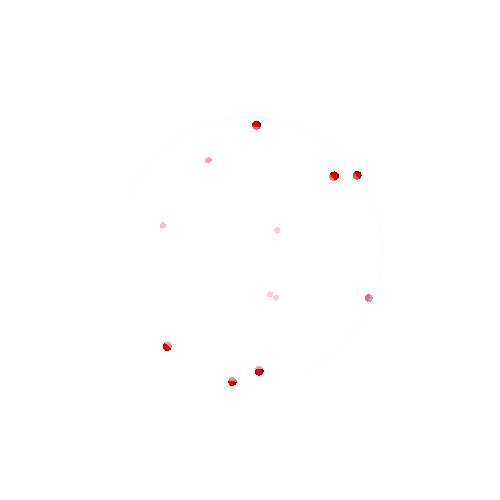

In [11]:
animate(lst).show()

In [34]:
plot_divisor_on_sphere(pencil_to_j(good_pencil).denominator())

[8.48813541290613e10 + 1.12242070107675e11*I, -6.67255711849758e11 - 8.20749989163964e11*I, 5.02283383050880e12 + 3.03153971343559e12*I, -2.06778269515769e13 - 3.88587315699232e12*I, 5.95339783723312e13 - 2.53662478675535e12*I, -1.33694207657241e14 + 4.19310640899205e13*I, 1.84128213314276e14 - 1.30463137173489e14*I, -1.89909862705286e14 + 1.83513559864585e14*I, 1.50850326910867e14 - 2.17232589867557e14*I, -5.27361124703878e13 + 1.56694397644596e14*I, 1.01202977224133e13 - 5.28012907170989e13*I, -1.60283560762012e13 + 1.08096906160599e13*I, 2.57351641929092e12 - 6.91859951494842e12*I]


Graphics3d Object

In [25]:
interactive_polynomial_sphere(degree=12, coeff_range=6.0)

Graphics3d Object

(3.71362410637351 - 1.15535240749852*I)*s^12 + (-3.38666125408611 + 1.48027320776402*I)*s^11*t + (-1.28781899169797 + 2.29442272698249*I)*s^10*t^2 + (1.41764958523658 - 2.24584940561875*I)*s^9*t^3 + (5.00761869962745 + 3.36082567593058*I)*s^8*t^4 + (-4.04836421046858 - 0.911978393439532*I)*s^7*t^5 + (0.0891697028725069 - 2.76359370870291*I)*s^6*t^6 + (-2.54179016409996 - 1.56193196750380*I)*s^5*t^7 + (1.19321425131214 + 4.65976955013469*I)*s^4*t^8 + (-1.34613509143225 + 1.20102181420101*I)*s^3*t^9 + (-4.01095662020275 - 5.45518963225680*I)*s^2*t^10 + (4.00378666408248 - 2.50368519853379*I)*s*t^11 + (5.66118256137494 - 1.07322218152380*I)*t^12


In [8]:
plot_divisor_on_sphere(hom_R_S(pol.denominator()))`

SyntaxError: invalid syntax (2721370716.py, line 1)

In [9]:
pol.denominator()

-4662774*s^12 - 2253172606/5*s^11*t - 136364093719/10*s^10*t^2 - 122994949199819/1000*s^9*t^3 - 4920329345278683/10000*s^8*t^4 - 24944708308981287/25000*s^7*t^5 - 1076149143063867711/1000000*s^6*t^6 - 739254596410565949/1250000*s^5*t^7 - 13180254590544642207/100000000*s^4*t^8 - 1364239486420538977/1000000000*s^3*t^9 - 376524289532537057/1000000000*s^2*t^10 - 13306549373339/20000000*s*t^11 - 11123599899/40000*t^12

In [10]:
hom(pol.denominator())

TypeError: hom() missing 2 required positional arguments: 'Y' and 'f'

In [11]:
hom(pol.numerator())

TypeError: hom() missing 2 required positional arguments: 'Y' and 'f'

In [12]:
pol

(-697864103*s^12 - 136798673106/5*s^11*t - 19013910962007/50*s^10*t^2 - 537427122498323/250*s^9*t^3 - 40787313166979649/10000*s^8*t^4 - 7163321209112097/2500*s^7*t^5 - 22557990114296853/50000*s^6*t^6 + 57939384390305589/1250000*s^5*t^7 - 7285534931553376761/100000000*s^4*t^8 + 2502758784653869411/250000000*s^3*t^9 - 10775564088082959207/5000000000*s^2*t^10 + 3566917347567019257/25000000000*s*t^11 - 13823982720007199999/1000000000000*t^12)/(-4662774*s^12 - 2253172606/5*s^11*t - 136364093719/10*s^10*t^2 - 122994949199819/1000*s^9*t^3 - 4920329345278683/10000*s^8*t^4 - 24944708308981287/25000*s^7*t^5 - 1076149143063867711/1000000*s^6*t^6 - 739254596410565949/1250000*s^5*t^7 - 13180254590544642207/100000000*s^4*t^8 - 1364239486420538977/1000000000*s^3*t^9 - 376524289532537057/1000000000*s^2*t^10 - 13306549373339/20000000*s*t^11 - 11123599899/40000*t^12)

In [13]:
pol.denominator()

-4662774*s^12 - 2253172606/5*s^11*t - 136364093719/10*s^10*t^2 - 122994949199819/1000*s^9*t^3 - 4920329345278683/10000*s^8*t^4 - 24944708308981287/25000*s^7*t^5 - 1076149143063867711/1000000*s^6*t^6 - 739254596410565949/1250000*s^5*t^7 - 13180254590544642207/100000000*s^4*t^8 - 1364239486420538977/1000000000*s^3*t^9 - 376524289532537057/1000000000*s^2*t^10 - 13306549373339/20000000*s*t^11 - 11123599899/40000*t^12

In [14]:
show(widgets.IntSlider(value=1, min=1, max=8, step=1,
                                   description='degree', continuous_update=False))

IntSlider(value=1, continuous_update=False, description='degree', max=8, min=1)

In [15]:
# Run this cell to see what is available
import sys
print("Python:", sys.version.splitlines()[0])

# ipywidgets
try:
    import ipywidgets as widgets
    print("ipywidgets:", widgets.__version__)
except Exception as e:
    print("ipywidgets: NOT AVAILABLE (", e, ")")

# Jupyter frontend info (if running in Jupyter)
try:
    from jupyter_core.paths import jupyter_path
    print("jupyter path ok")
except Exception:
    pass

# threejs viewer availability check (Sage's viewer uses threejs)
try:
    from sage.interfaces.ipython import html_widgets
    print("sage html_widgets import OK")
except Exception as e:
    print("sage html_widgets import failed:", e)

# Basic test to check if widgets display is enabled
try:
    import IPython
    display_obj = IPython.display.HTML("<small>If you see this HTML, display works.</small>")
    from IPython.display import display
    display(display_obj)
    print("Displayed a test HTML block in output — if you can see it, basic display works.")
except Exception as e:
    print("Could not display test HTML:", e)


Python: 3.13.7 (main, Aug 15 2025, 12:34:02) [GCC 15.2.1 20250813]
ipywidgets: 8.1.7
jupyter path ok
sage html_widgets import failed: No module named 'sage.interfaces.ipython'


Displayed a test HTML block in output — if you can see it, basic display works.
